In [1]:
from rdkit import Chem
import pandas as pd
from rdkit.Chem import PandasTools

from IPython.display import HTML
def show_df(df):
    return HTML(df.to_html(notebook=True))

# Import Moonshot file

In [2]:
moonshot_file = "../../covid_submissions_all_info.csv"
df = pd.read_csv(moonshot_file)
PandasTools.AddMoleculeColumnToFrame(df,'SMILES','Molecule')

/home/nichrun/miniconda3/envs/data_driven_fep_rel/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (3,6,7,9,10,11,12,13,14,15,18,19,27,28,29,30,31,32,33,34,35,36,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,66,67,69,70,71,72,73,74,75,76,84,85,86,87,89,90,91,92,93,94,95,96,104,105,106,107,109,110,111,112,113,114,115,116,124,125,126,127,129,130,131,132,133,134,135,136,144,145,146,147,149,150,151,152,153,154,155,156,164,165,166,167,169,170,171,172,173,174,175,176,184,185,186,187,189,190,191,192,193,194,195,196,204,205,206,207,209,210,211,212,213,214,215,216,224,225,226,227,229,230,231,232,233,234,235,236,244,245,246,247,249,253,254,255,256,257,258,259,275,276) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
[14:36:59] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [14:36:59] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [14:36

In [3]:
def MolFromName(name):
    """
    Function to find molecule in dataframe by CID
    input: (string) CID
    output: (object) mol
    """
    reference_row = df[df["CID"] == name]
    if len(reference_row) == 1:
        return Chem.MolFromSmiles(reference_row.iloc[0]["SMILES"])
    else:
        print("Name not found in df")
        return False

# Murcko

In [4]:
from rdkit.Chem.Scaffolds import MurckoScaffold
from rdkit.Chem import rdchem

def GetTrueScaffold(mol,generic=False):
    #Not sure if hybridisation of dummy atom is correct
    #Not sure on properties
    #Seems to work as desired
    """
    Takes RDKit mol object
    Returns mol object of the murcko scaffold with original algorithm
    Stereochemistry is lost
    """
    mol = MurckoScaffold.GetScaffoldForMol(mol)
    atom_to_remove = []
    atom_to_clean = []
    
    for a in mol.GetAtoms():
        #Remove chirality
        mol.GetAtomWithIdx(a.GetIdx()).SetChiralTag(Chem.ChiralType.CHI_UNSPECIFIED)
        
        #For atoms bonded to only one other atom, these must be removed
        if len(a.GetBonds()) == 1:
            #Get index of atom to delete and append to deletion list
            atom_to_remove.append(a.GetIdx())

    #If there are atoms to delte
    if len(atom_to_remove) > 0:
        #Create an editable molecule (now RW)
        emol = rdchem.RWMol(mol)
        #Every time an atom is delted the index changes
        #Deletion list must be reversed to avoid rogue deletions
        for a in atom_to_remove[::-1]:
            #Remove atom by index a
            emol.RemoveAtom(a)
    #If the molecule is already the correct murcko scaffold set emol = mol
    else:
        emol = mol
    
    #This line used to cause errors
    #SanitizeMol(emol) often failed due to aromaticity
    #Attempts to solve this included replacing previously bonded atoms with the
    #wild card *
    #It seems clearing aromatic flags solved the issue
    try:
        #Clearing aromatic flags seems to fix everything
        Chem.Kekulize(emol,clearAromaticFlags=True)
        Chem.SanitizeMol(emol)
    except:
        #Error
        #Will show the input molecule and attempted editted molecule (before)
        display("Input Mol")
        display(mol)
        display("Output Emol")
        display(emol)
        raise ("Error in santisation of new molecule")
        return False
    
    #The above procedure will remove all remaining decorating groups on scaffold
    #In some cases (like sulfonyl) this will leave an aliphatic chain
    #Additional application of MurckoScaffold algorithm is needed
    #However the RDKit implementation is sufficient 
    emol = MurckoScaffold.GetScaffoldForMol(emol)
    
    #If the generic scaffold is desired (Flag), make generic
    if generic:
        emol = MurckoScaffold.MakeScaffoldGeneric(emol)

    #Return the molecule
    return emol

In [5]:
#Use a smaller dataframe without all the excess data
#Just take CID (name) and molecule object
mol_df = df[["CID", "Molecule"]]

In [6]:
#Apply murcko algorithm and create new column with the full and generic scaffolds

mol_df["TrueMurcko"] = df.apply(lambda x: GetTrueScaffold(x["Molecule"]), axis = 1)
mol_df["TrueMurckoGeneric"] = df.apply(lambda x: GetTrueScaffold(x["Molecule"],generic=True), axis = 1)

/home/nichrun/miniconda3/envs/data_driven_fep_rel/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/home/nichrun/miniconda3/envs/data_driven_fep_rel/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


,CID,Molecule,TrueMurcko,TrueMurckoGeneric
0,ANT-DIA-3c79be55-1,,,
1,ANT-DIA-3c79be55-2,,,
2,ANT-DIA-3c79be55-3,,,
3,ANT-DIA-3c79be55-4,,,
4,ANT-DIA-3c79be55-5,,,
5,ROB-UNI-b2e39629-1,,,
6,ROB-UNI-b2e39629-2,,,
7,ROB-UNI-b2e39629-3,,,
8,ROB-UNI-b2e39629-4,,,
9,ROB-UNI-b2e39629-5,,,

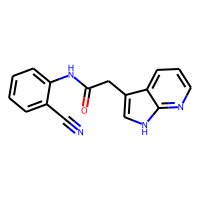
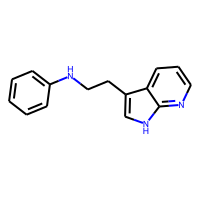
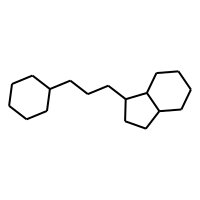
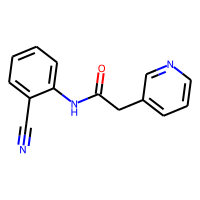
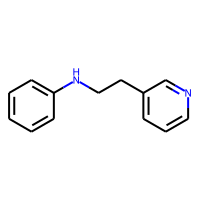
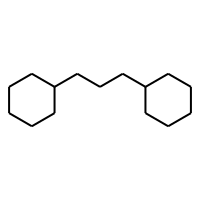
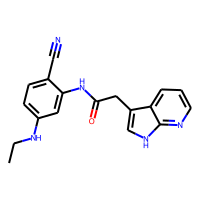
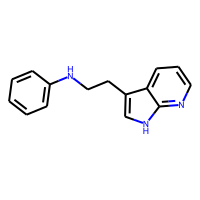
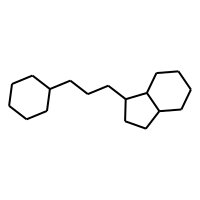
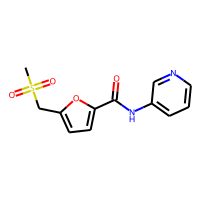
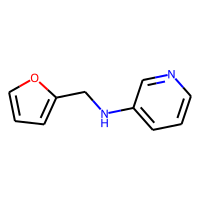
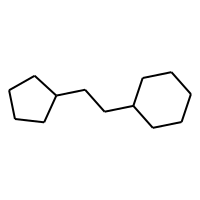
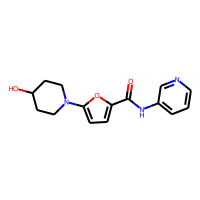
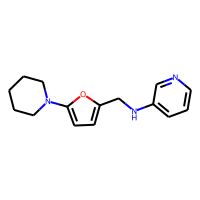
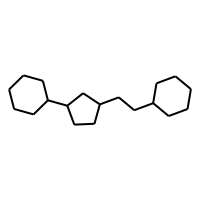
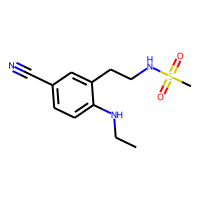
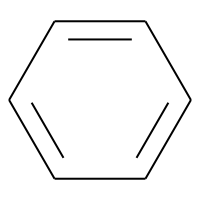
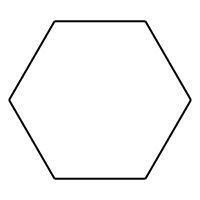
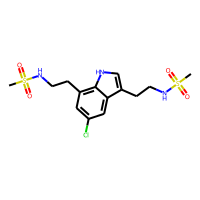
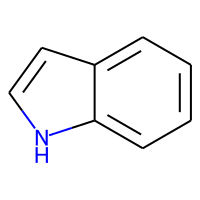
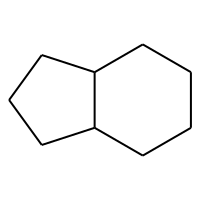
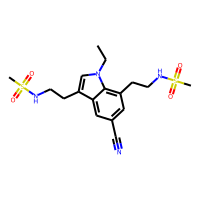
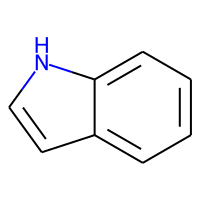
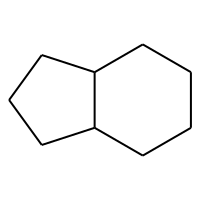
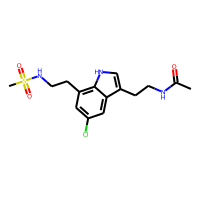
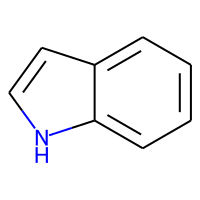
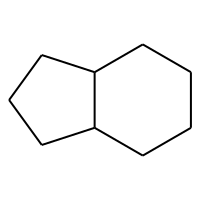
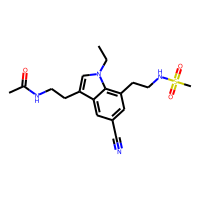
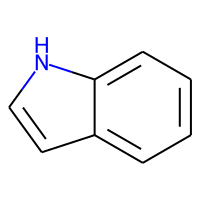
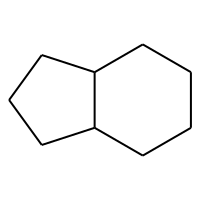
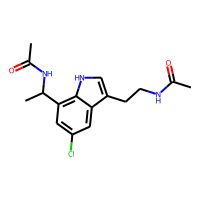
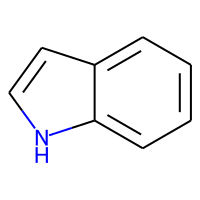
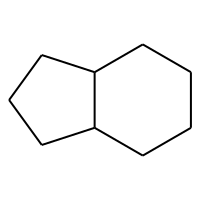
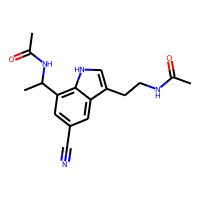
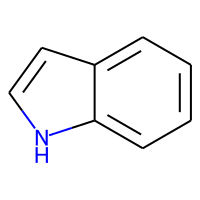
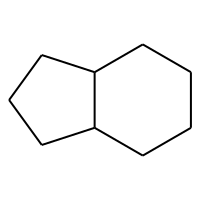
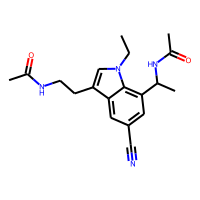
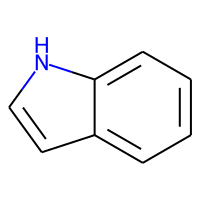
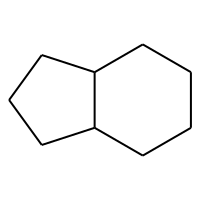
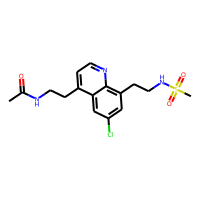
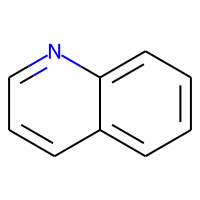
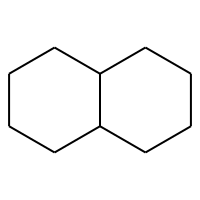
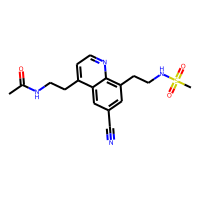
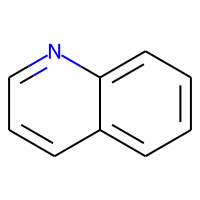
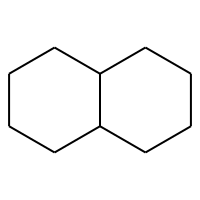
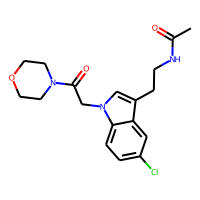
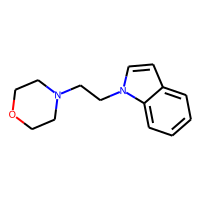
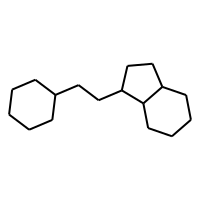
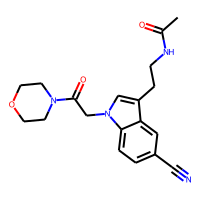
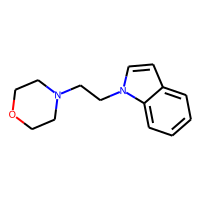
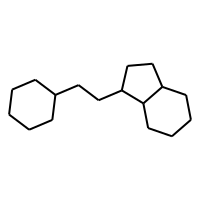
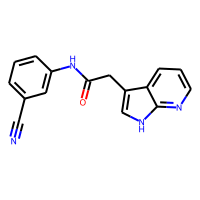
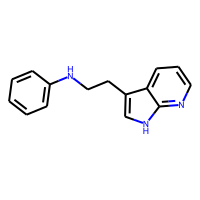
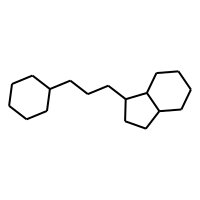
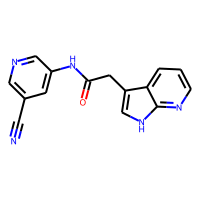
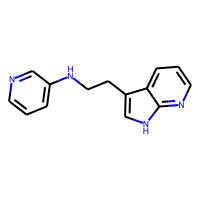
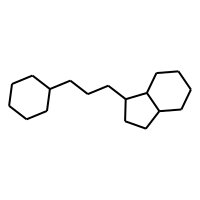
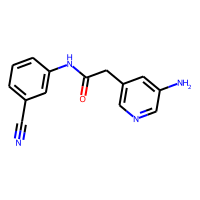
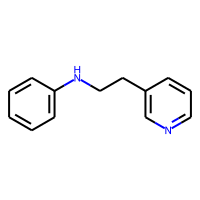
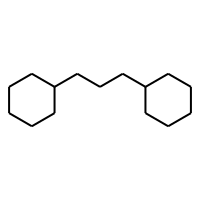

In [7]:
#comparison of diffrent murcko scaffolds
show_df(mol_df.head(20))

# Exploration

In [8]:
from rdkit import Chem
from rdkit.Chem import rdMolHash
import rdkit

# Considering the Murcko Scaffold (with atom identity)

In [9]:
#Take hash of scaffold
mol_df["mHash"] = mol_df.apply(lambda x: rdMolHash.MolHash(x["TrueMurcko"], rdkit.Chem.rdMolHash.HashFunction.MurckoScaffold), axis = 1)

/home/nichrun/miniconda3/envs/data_driven_fep_rel/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


/home/nichrun/miniconda3/envs/data_driven_fep_rel/lib/python3.7/site-packages/rdkit/Chem/Draw/IPythonConsole.py:192: UserWarning: Truncating the list of molecules to be displayed to 50. Change the maxMols value to display more.
  % (maxMols))


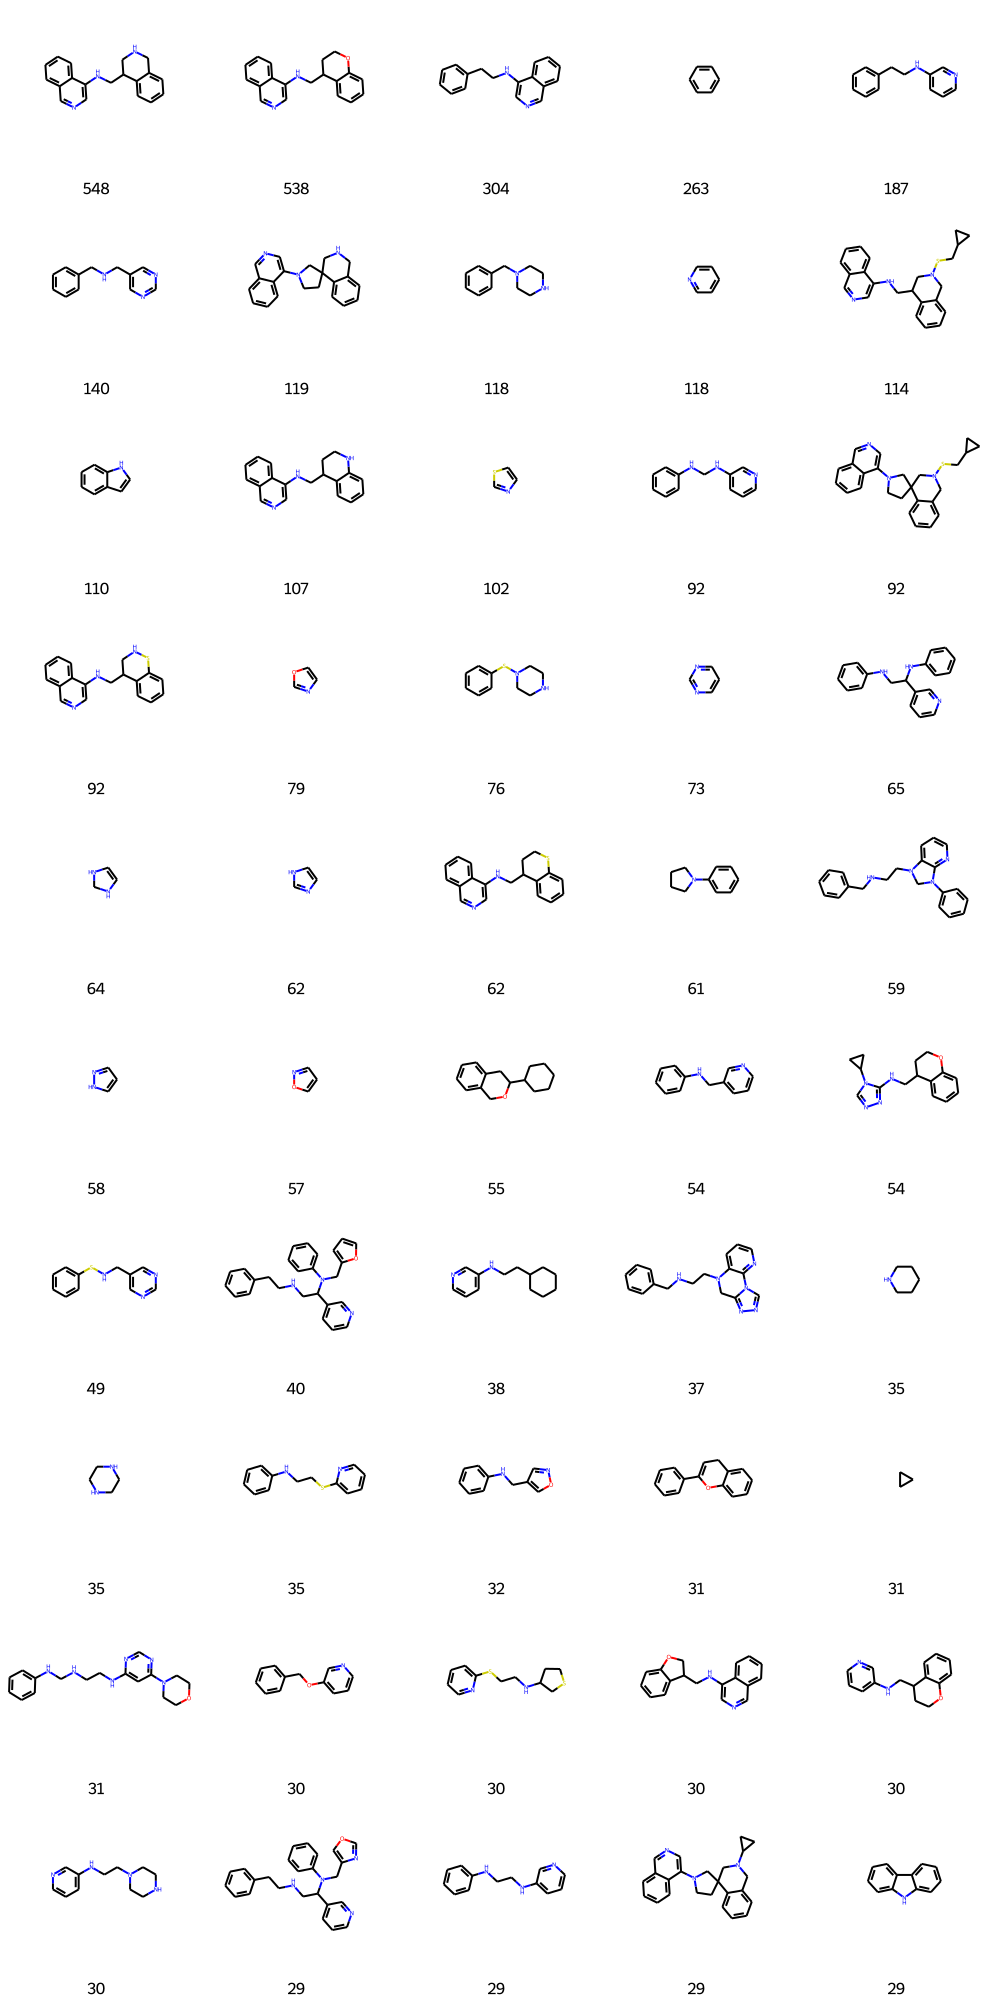

In [10]:
from rdkit.Chem import Draw

#Create dataframe of just scaffolds
#Select the 100 most common scaffolds
scaffolds = mol_df.groupby(['mHash']).size()
scaffolds_df = scaffolds.nlargest(100).to_frame(name="counts")

#Remove empty index row as this breaks everything
#There are 73 cases of empty scaffolds (no ring)
scaffolds_df.drop(labels="", inplace=True)

#Turn scaffold hash into a molecule for visualisation
scaffolds_df["scaffolds"] = scaffolds_df.apply(lambda x: Chem.MolFromSmiles(x.name), axis = 1)
#Create legend labels to show below molecule (this is the number of occuranced of the scaffold)
legends = [str(x) for x in list(scaffolds_df["counts"])]

#Visualise
Draw.MolsToGridImage(list(scaffolds_df["scaffolds"]),subImgSize=(200,200),molsPerRow=5,legends = legends)

# Considering the Generic Murcko Scaffold (without atom identity)

/home/nichrun/miniconda3/envs/data_driven_fep_rel/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


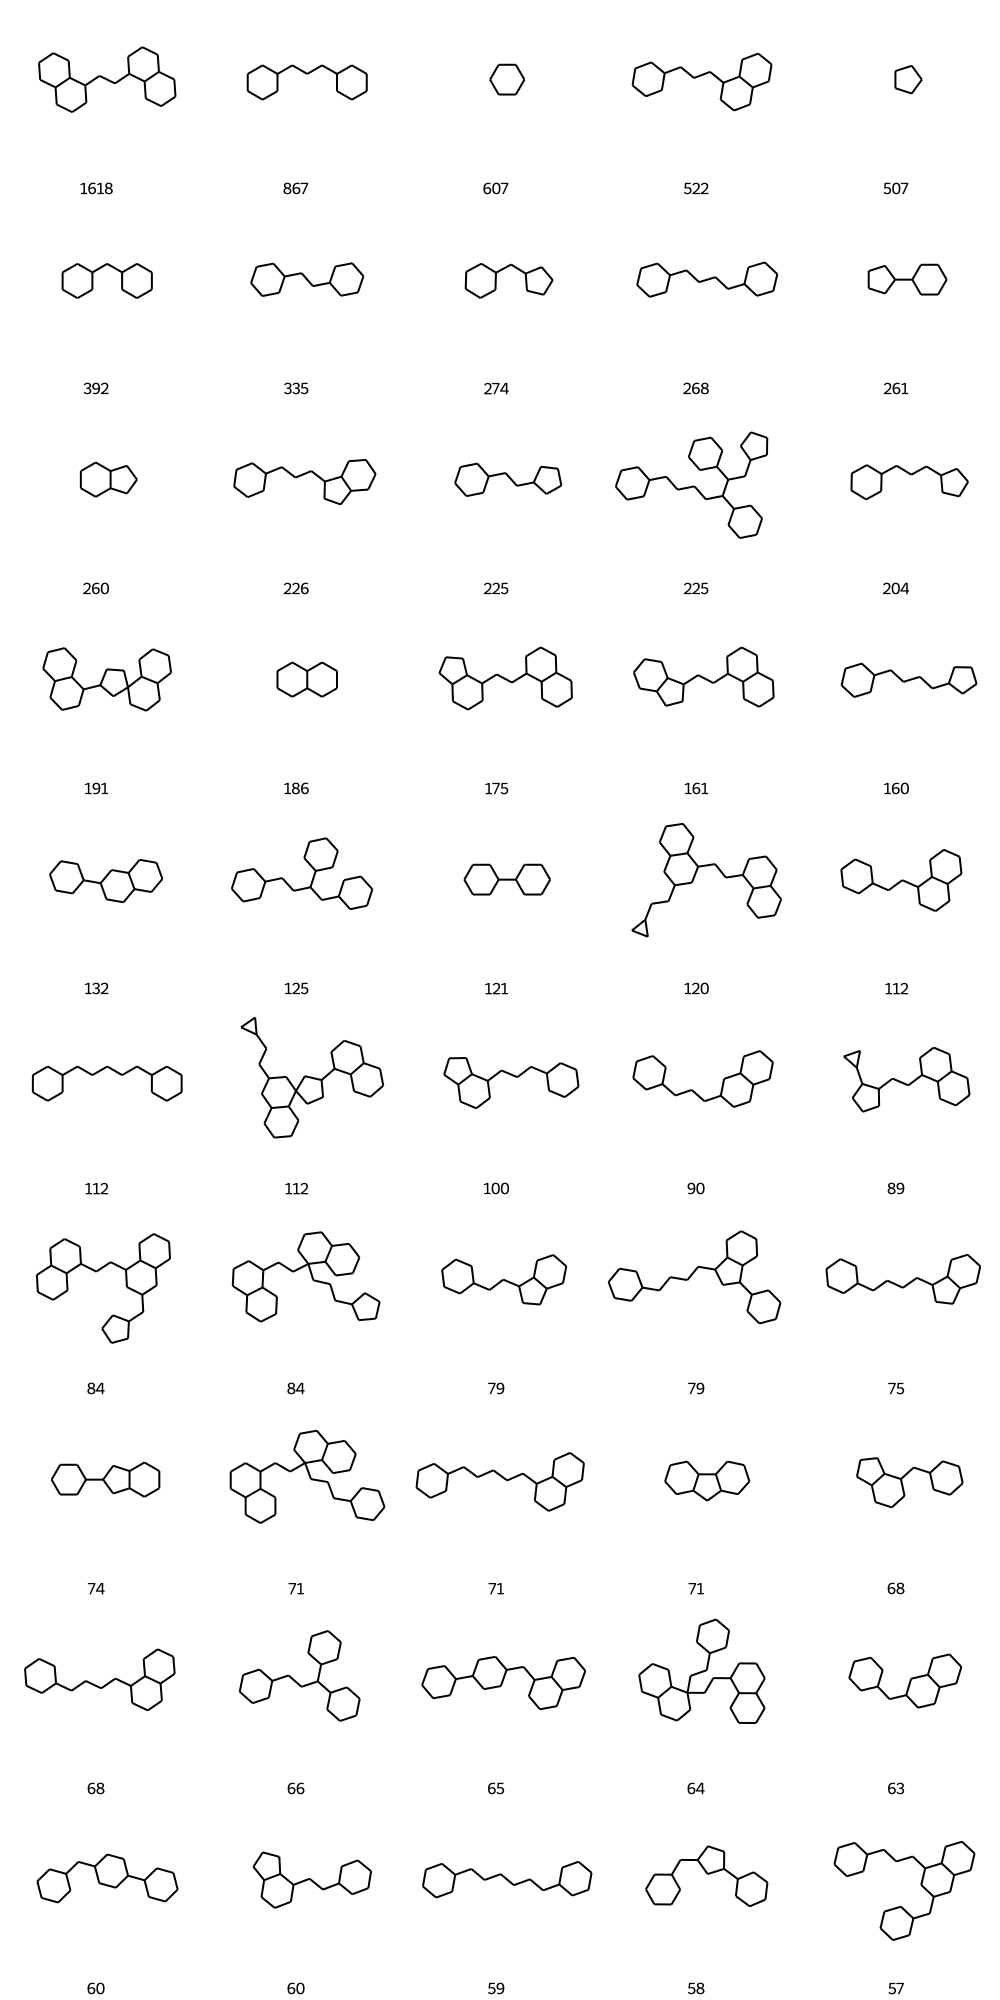

In [11]:
#Take hash of scaffold
mol_df["mHashGeneric"] = mol_df.apply(lambda x: rdMolHash.MolHash(x["TrueMurckoGeneric"], rdkit.Chem.rdMolHash.HashFunction.MurckoScaffold), axis = 1)

#Create dataframe of just scaffolds
#Select the 100 most common scaffolds
scaffolds = mol_df.groupby(['mHashGeneric']).size()
scaffolds_df = scaffolds.nlargest(100).to_frame(name="counts")

#Remove empty index row as this breaks everything
#There are 73 cases of empty scaffolds (no ring)
scaffolds_df.drop(labels="", inplace=True)

#Turn scaffold hash into a molecule for visualisation
scaffolds_df["scaffolds"] = scaffolds_df.apply(lambda x: Chem.MolFromSmiles(x.name), axis = 1)
#Create legend labels to show below molecule (this is the number of occuranced of the scaffold)
legends = [str(x) for x in list(scaffolds_df["counts"])]

#Visualise
Draw.MolsToGridImage(list(scaffolds_df["scaffolds"]),subImgSize=(200,200),molsPerRow=5,legends = legends)